In [1]:
import arrayfire as af
import numpy as np
import pylab as pl

from bolt.lib.physical_system import physical_system
from bolt.lib.nonlinear.nonlinear_solver import nonlinear_solver
from bolt.lib.linear.linear_solver import linear_solver
from bolt.lib.linear.utils.fft_funcs import fft2, ifft2

import domain
import boundary_conditions
import params
import initialize

import bolt.src.nonrelativistic_boltzmann.advection_terms as advection_terms
import bolt.src.nonrelativistic_boltzmann.collision_operator as collision_operator
import bolt.src.nonrelativistic_boltzmann.moments as moments

%matplotlib inline

# Optimized plot parameters to make beautiful plots:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['figure.dpi']      = 300
pl.rcParams['image.cmap']      = 'jet'
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

In [9]:
# Time parameters:
t_final = 0.1
N       = 64

domain.N_q1 = int(N)
domain.N_p1 = int(N)

if (params.p_dim==2):
    domain.N_q2 = int(N)
    domain.N_p2 = int(N)

dt = 32*1e-3/N

# Defining the physical system to be solved:
system = physical_system(domain,
                         boundary_conditions,
                         params,
                         initialize,
                         advection_terms,
                         collision_operator.BGK,
                         moments
                        )

N_g_q = system.N_ghost_q

# Declaring a linear system object which will evolve the defined physical system:
nls = nonlinear_solver(system)
ls  = linear_solver(system)

n_nls = []
n_ls  = []

E1_nls = []
E2_nls = []
E3_nls = []
B1_nls = []
B2_nls = []
B3_nls = []

E1_ls = []
E2_ls = []
E3_ls = []
B1_ls = []
B2_ls = []
B3_ls = []
   
# Storing data at time t = 0:

n_nls.append(nls.compute_moments('density'))
E1_nls.append(nls.fields_solver.cell_centered_EM_fields[0])
E2_nls.append(nls.fields_solver.cell_centered_EM_fields[1])
E3_nls.append(nls.fields_solver.cell_centered_EM_fields[2])
B1_nls.append(nls.fields_solver.cell_centered_EM_fields[3])
B2_nls.append(nls.fields_solver.cell_centered_EM_fields[4])
B3_nls.append(nls.fields_solver.cell_centered_EM_fields[5])
    
n_ls.append(ls.compute_moments('density'))
E1_ls.append(0.5 * ls.N_q1 * ls.N_q2 * af.real(ifft2(ls.fields_solver.fields_hat[0])) )
E2_ls.append(0.5 * ls.N_q1 * ls.N_q2 * af.real(ifft2(ls.fields_solver.fields_hat[1])) )
E3_ls.append(0.5 * ls.N_q1 * ls.N_q2 * af.real(ifft2(ls.fields_solver.fields_hat[2])) )
B1_ls.append(0.5 * ls.N_q1 * ls.N_q2 * af.real(ifft2(ls.fields_solver.fields_hat[3])) )
B2_ls.append(0.5 * ls.N_q1 * ls.N_q2 * af.real(ifft2(ls.fields_solver.fields_hat[4])) )
B3_ls.append(0.5 * ls.N_q1 * ls.N_q2 * af.real(ifft2(ls.fields_solver.fields_hat[5])) )

In [10]:
time_array  = np.arange(dt, t_final + dt, dt)

for time_index, t0 in enumerate(time_array):

    print('time_step = ', time_index, 'of ', time_array.size)
    nls.strang_timestep(dt)
    ls.RK4_timestep(dt)

    n_nls.append(nls.compute_moments('density'))
    E1_nls.append(nls.fields_solver.cell_centered_EM_fields[0])
    E2_nls.append(nls.fields_solver.cell_centered_EM_fields[1])
    E3_nls.append(nls.fields_solver.cell_centered_EM_fields[2])
    B1_nls.append(nls.fields_solver.cell_centered_EM_fields[3])
    B2_nls.append(nls.fields_solver.cell_centered_EM_fields[4])
    B3_nls.append(nls.fields_solver.cell_centered_EM_fields[5])
    
    n_ls.append(ls.compute_moments('density'))
    E1_ls.append(0.5 * ls.N_q1 * ls.N_q2 * af.real(ifft2(ls.fields_solver.fields_hat[0])) )
    E2_ls.append(0.5 * ls.N_q1 * ls.N_q2 * af.real(ifft2(ls.fields_solver.fields_hat[1])) )
    E3_ls.append(0.5 * ls.N_q1 * ls.N_q2 * af.real(ifft2(ls.fields_solver.fields_hat[2])) )
    B1_ls.append(0.5 * ls.N_q1 * ls.N_q2 * af.real(ifft2(ls.fields_solver.fields_hat[3])) )
    B2_ls.append(0.5 * ls.N_q1 * ls.N_q2 * af.real(ifft2(ls.fields_solver.fields_hat[4])) )
    B3_ls.append(0.5 * ls.N_q1 * ls.N_q2 * af.real(ifft2(ls.fields_solver.fields_hat[5])) )

nls.dump_distribution_function('dump_files/nlsf_' + str(N))
ls.dump_distribution_function('dump_files/lsf_' + str(N))

time_step =  0 of  200
time_step =  1 of  200
time_step =  2 of  200
time_step =  3 of  200
time_step =  4 of  200
time_step =  5 of  200
time_step =  6 of  200
time_step =  7 of  200
time_step =  8 of  200
time_step =  9 of  200
time_step =  10 of  200
time_step =  11 of  200
time_step =  12 of  200
time_step =  13 of  200
time_step =  14 of  200
time_step =  15 of  200
time_step =  16 of  200
time_step =  17 of  200
time_step =  18 of  200
time_step =  19 of  200
time_step =  20 of  200
time_step =  21 of  200
time_step =  22 of  200
time_step =  23 of  200
time_step =  24 of  200
time_step =  25 of  200
time_step =  26 of  200
time_step =  27 of  200
time_step =  28 of  200
time_step =  29 of  200
time_step =  30 of  200
time_step =  31 of  200
time_step =  32 of  200
time_step =  33 of  200
time_step =  34 of  200
time_step =  35 of  200
time_step =  36 of  200
time_step =  37 of  200
time_step =  38 of  200
time_step =  39 of  200
time_step =  40 of  200
time_step =  41 of  200
ti

In [11]:
import h5py

# Checking the errors
def check_convergence():
    N     = np.array([32, 48, 64])
    error = np.zeros(N.size)
    
    for i in range(N.size):

        print("N = ", i)
        h5f   = h5py.File('dump_files/nlsf_' + str(N[i]) + '.h5')
        nls_f = h5f['distribution_function'][:]
        h5f.close()    

        h5f  = h5py.File('dump_files/lsf_' + str(N[i]) + '.h5')
        ls_f = h5f['distribution_function'][:]
        h5f.close()

        error[i] = np.mean(abs(nls_f - ls_f))

    print(error)
    poly = np.polyfit(np.log10(N), np.log10(error), 1)
    print(poly)

    pl.loglog(N, error, 'o-', label = 'Numerical')
    pl.loglog(N, error[0]*32**2/N**2, '--', color = 'black', 
              label = r'$O(N^{-2})$'
             )
    pl.legend(loc = 'best')
    pl.ylabel('Error')
    pl.xlabel('$N$')

N =  0
N =  1
N =  2
[  2.49766950e-10   1.05433141e-10   5.86264486e-11]
[-2.09332892 -6.45343354]


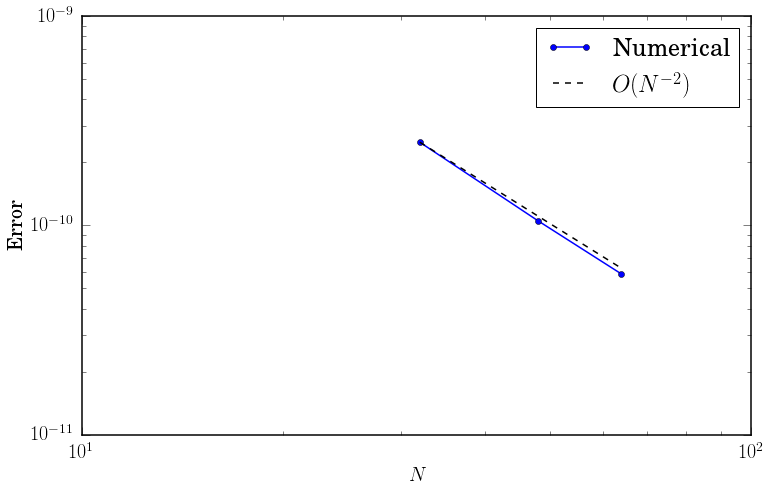

In [12]:
check_convergence()

In [ ]:
N_g = domain.N_ghost_q

for i in range(0, 100, 1):
    pl.plot(np.array(ls.q1_center)[0, 0, :, 1], np.array(E1_ls[i])[0, 0, :, 1], '--', color='black', lw=2)
    pl.plot(np.array(nls.q1_center)[0, 0, N_g:-N_g, 1], np.array(E1_nls[i])[0, 0, N_g:-N_g, N_g], color='blue')

In [ ]:
np.array(ifft2(ls.fields_solver.E1_hat))

In [ ]:
rho_hat = params.charge*ls.compute_moments('density', f_hat=ls.f_hat)
rho     = 0.5 * ls.N_q1 * ls.N_q2 * af.real(ifft2(rho_hat))

ls.fields_solver.compute_electrostatic_fields(rho_hat)
E1 = 0.5 * ls.N_q1 * ls.N_q2 * af.real(ifft2(ls.fields_solver.E1_hat))

pl.plot(np.array(ls.q1_center)[0, 0, :, 1], np.array(E1)[0, 0, :, 1])
#pl.plot(np.array(ls.q1_center)[0, 0, :, 1], np.array(E1_ls[time_step])[0, 0, :, 1])
pl.plot(np.array(nls.q1_center)[0, 0, N_g:-N_g, 1], np.array(E1_nls[time_step])[0, 0, N_g:-N_g, N_g])

In [4]:
ls.fields_solver.fields_hat.shape

(6, 1, 32, 32)